In [1]:
import stream_time_reversability as STR
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import tstrippy
import datetime
import multiprocessing as mp
from astropy import units as u
from astropy.coordinates import SkyCoord
import h5py

In [2]:
integrationtime = 1/100
currenttime = 0 

In [3]:
MWparams = tstrippy.Parsers.pouliasis2017pii()
dtfactor = 1/100
staticgalaxy = ["pouliasis2017pii", MWparams]
G = MWparams[0]
M = 1e5
a = 5e-3
NP = int(1e2)
aplum = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(a)
tau = STR.plummer_dynamical_time([G,M,a])

In [4]:
targetGC = "NGC6760"
initialkinematics = STR.pick_GC_get_kinematics(targetGC)

In [5]:
integrationparameters = STR.prepare_integration_arguments(currenttime=currenttime,
                                                          integrationtime=integrationtime,
                                                          tdyn=tau,
                                                          alpha=dtfactor)

print("nsteps", integrationparameters[-1])
integrationparameters = list(integrationparameters)


nsteps 2048


In [6]:
args = initialkinematics, staticgalaxy, integrationparameters
orbit, timestamps, comptime = STR.integrate_host_orbit_back(args)

integration time:  0:00:00.006334


In [7]:
integrationparameters

[0, np.float64(4.882812500000001e-06), 2048]

In [8]:
inithostperturber = [timestamps, *orbit, G, M, aplum ]
xp,yp,zp,vxp,vyp,vzp = tstrippy.ergodic.isotropicplummer(G,M,a,NP)
integrationparameters_stream = [timestamps[0],*integrationparameters[1:]]
initialkinematics_stream = [xp+orbit[0,0], yp+orbit[1,0], zp+orbit[2,0], vxp+orbit[3,0], vyp+orbit[4,0], vzp+orbit[5,0]]

In [9]:
streaminit = np.array([xp, yp, zp, vxp, vyp, vzp]).T + orbit[:,0]

In [10]:
args_stream = initialkinematics_stream, staticgalaxy, integrationparameters_stream, inithostperturber
stream,tesc, comptime = STR.leapfrogtofinalpositions_stream(args_stream)
print(f"Stream generation took {comptime} seconds")

Stream generation took 0.082234 seconds


In [11]:
# dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,0][:,np.newaxis]).T
dx,dy,dz,dvx,dvy,dvz=(stream - orbit[:,-1][:,np.newaxis])
dr = np.sqrt(dx**2 + dy**2 + dz**2)
phi0 = -G*M/(dr**2 + aplum**2)**(1/2)
T0 = (1/2) * (dvx**2 + dvy**2 + dvz**2) 
E0 = phi0 + T0

In [12]:
NSTEP = int(1e6)
NP = int(1e5)
Nc = 80e-9
Nmc = 50
NGC = 165
comptime=Nmc*NGC*NSTEP*NP*Nc * u.s
comptime.to(u.day) / 100

<Quantity 7.63888889 d>

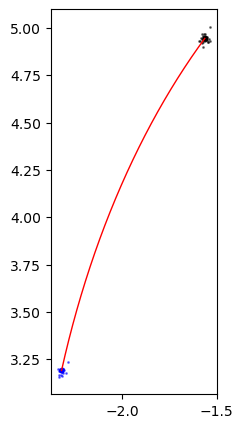

In [13]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,5))
axis.scatter(stream[0], stream[1], s=1, c='k', alpha=0.5)
axis.scatter(xp+orbit[0,0], yp+orbit[1,0], s=1, c='b', alpha=0.5, label='Stream particles')
axis.plot(orbit[0],orbit[1], c='r', lw=1, label='Host orbit')
axis.set_aspect('equal')

# Computation time

$$C(N_p, N_{\text{Steps}}) = A \cdot N_p^\alpha \cdot N_{\text{Steps}}^\beta $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$

$$\log C = \log A + \alpha \log N_p + \beta \log N_{\text{Steps}} $$


In [14]:
alphas = np.logspace(1,-2.5,5) # the dt factors

In [15]:
# parameters of the experiment
Nc = 80e-9 # mean time per single step 
NPs = np.logspace(0,4,5,dtype=int)
alphas = np.logspace(1,-2.5,5) # the dt factors
targetGC = "NGC6760"
integrationtime = .1*u.Gyr
# reverse the order so the heavy comps come first 
alphas = alphas[::-1]
NPs = NPs[::-1]
# convert to integration units 
integrationtime=integrationtime.to(u.s * (u.kpc/u.km)).value

In [16]:
# get the static galaxy, which doesn't change 
MWparams = tstrippy.Parsers.pouliasis2017pii()
staticgalaxy = ['pouliasis2017pii', MWparams]

In [17]:
# Extract the GC initial conditions 
GCdata=tstrippy.Parsers.baumgardtMWGCs().data
GCindex = np.where(GCdata['Cluster'] == targetGC)[0][0]
Mass = GCdata['Mass'][GCindex].value
rhm = GCdata['rh_m'][GCindex].value
tau=STR.plummer_dynamical_time([G,Mass,rhm])
clusterinitialkinematics = STR.pick_GC_get_kinematics(targetGC)

In [18]:
currenttime=0
# PREPARE THE ARGUMENTS FOR EACH SIMULATION 
streamInitialKinematics = {}
for i in range(len(NPs)):
    streamInitialKinematics[i] = np.array(tstrippy.ergodic.isotropicplummer(G, Mass, rhm, NPs[i]))
integrationparameters = {}
NSTEPS = []
for i in range(len(alphas)):
    integrationparameters[i] = STR.prepare_integration_arguments(currenttime=currenttime,
                                                                                 integrationtime=integrationtime,
                                                                                 tdyn=tau,
                                                                                 alpha=alphas[i],)
    NSTEPS.append(integrationparameters[i][-1])

In [19]:
hostparams = [G, Mass, aplum]
arguments = []
for i in range(len(NPs)):
    for j in range(len(alphas)):
        args = (staticgalaxy, integrationparameters[j], clusterinitialkinematics, hostparams,
                streamInitialKinematics[i],)
        arguments.append(args)

In [20]:
args = arguments[-8]
mystaticgalaxy, myintegrationparameters, myclusterinitialkinematics, myhostsparams, myinitialstream=args

In [21]:
hostorbit, timestamps, comptimestream = STR.integrate_host_orbit_back([myclusterinitialkinematics, mystaticgalaxy, myintegrationparameters,])
initialkinematics = myinitialstream + hostorbit[:,0][:,np.newaxis] # shift to the host's initial position 
inithostperturber = [timestamps, *hostorbit, *myhostsparams ]
integrationparameters_stream = [timestamps[0], *myintegrationparameters[1:]]
streamfinal,tesc,comptimestream = STR.leapfrogtofinalpositions_stream([initialkinematics, mystaticgalaxy, integrationparameters_stream, inithostperturber])

integration time:  0:00:00.006366


In [21]:
attrs = {
    "GCname": targetGC,
    "Note": "An experiment testing the scaling of the computation for integrating the most typical GC"
}
fname = "./simulations/{:s}_stream_NSTEPS_{:d}_NP_{:d}_comp_time_experiment.hdf5".format(attrs['GCname'], myintegrationparameters[-1], NPs[i])

In [22]:
allargs = (mystaticgalaxy, myintegrationparameters, myclusterinitialkinematics, myhostsparams, myinitialstream, attrs)
STR.generate_stream_leapfrogtofinalpositions_and_save(allargs)

Running simulation for NGC6760 with Nsteps=2048 and NP=10
integration time:  0:00:00.005757
Saved results to ./simulations/NGC6760_stream_NSTEPS_2048_NP_10_comp_time_experiment.hdf5


In [31]:
# now what do we want to write out?
newfile = h5py.File(fname, 'w')
newfile.create_dataset('hostorbit', data=hostorbit)
newfile.create_dataset('plummer', data=myinitialstream)
newfile.create_dataset('streamfinal', data=streamfinal)
newfile.create_dataset('timestamps', data=timestamps)
newfile.create_dataset('integrationparameters', data=myintegrationparameters)
newfile.attrs['staticgalaxy'] = mystaticgalaxy[0]
newfile.attrs['galaxyparams'] = mystaticgalaxy[1]
newfile.create_dataset('streamcomptime', data=comptimestream)
newfile.attrs['hostparams'] = myhostsparams
for key, value in attrs.items():
    newfile.attrs[key] = value

In [ ]:
fname = "./simulations/{:s}_stream_NSTEPS_{:d}_NP_{:d}_comp_time_experiment.hdf5".format(attrs['GCname'], 2048, 10)
myfile = h5py.File(fname, 'r')

In [39]:
NP = streamfinal.shape[1]
Nstep = hostorbit.shape[1]
myfile['comptimestream'][()]/NP/Nstep


np.float64(1.1078086871644706e-06)

In [ ]:
streamfinal=myfile['streamfinal']
hostorbit = myfile['hostorbit']
myinitialstream = myfile['streaminitial']

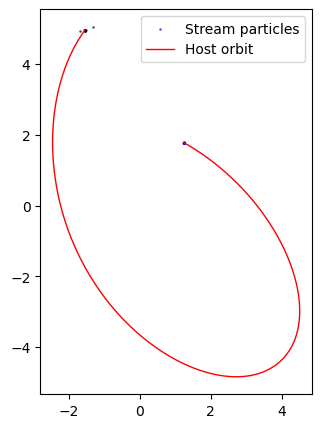

In [33]:
fig,axis= plt.subplots(1,1,figsize=(8.25-2,5))
axis.scatter(streamfinal[0], streamfinal[1], s=1, c='k', alpha=0.5)
axis.scatter(myinitialstream[0]+hostorbit[0,0], myinitialstream[1]+hostorbit[1,0], s=1, c='b', alpha=0.5, label='Stream particles')
axis.plot(hostorbit[0], hostorbit[1], c='r', lw=1, label='Host orbit')
axis.set_aspect('equal')
axis.legend()

In [ ]:
# psuedo code 

# input arguemnts 
# GCname, NP, alpha 

# 1. generate host orbit

# 2. generate initial stream conditions 

# 3. integrate stream forward in time

# output
# total computation time, energy conservation error 